# Gas CART

## Import and load

In [1]:
import sys
sys.path.insert(1, '../') 
from utils.loader import Loader
from utils.data_processor import Data_processor
from utils.cluster_generator import ClusterGenerator
from utils.master_generator import MasterGenerator

import pandas as pd
from sklearn import tree
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.decomposition import PCA,TruncatedSVD
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import chi2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from utils.evaluator import Evaluator
import prince
import numpy as np
from sklearn.svm import SVC, SVR
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


/home/lingfeng/Desktop/cuml/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-12-22 00:09:43.614285: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-22 00:09:43.738083: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734822583.790494   21858 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734822583.804551   21858 cuda_blas.cc:1418] Un

### Load GAS type cars

In [2]:
data = Loader.load_by_fueltype("Gas")
label_encoder = LabelEncoder()

/home/lingfeng/Desktop/repos/Cars_Price_Prediction/Trees/../utils/loader.py:153: DtypeWarning: Columns (120) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path,
/home/lingfeng/Desktop/repos/Cars_Price_Prediction/Trees/../utils/loader.py:153: DtypeWarning: Columns (120) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path,
/home/lingfeng/Desktop/repos/Cars_Price_Prediction/Trees/../utils/loader.py:165: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the 

In [3]:
data["price_categ"].value_counts()

price_categ
Middle low range     509
Budget               480
Low end              250
Middle range          31
Middle high range     16
Very low end           3
High end               1
Luxury                 0
Premiun                0
Name: count, dtype: int64

In [4]:
data['price_categ'] = data['price_categ'].replace({ # Combinar clases similares
    'Luxury': 'Alto',
    'Premiun': 'Alto',
    'High end': 'Alto',
    'Middle high range': 'Alto',
})

data = data[data['price_categ'] != 'Very low end'] # Eliminar la clase 'Very low end'
data['price_categ'] = data['price_categ'].str.strip()

# Revisa la nueva distribución
data['price_categ'].value_counts()

/tmp/ipykernel_21858/787252135.py:1: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  data['price_categ'] = data['price_categ'].replace({ # Combinar clases similares


price_categ
Middle low range    509
Budget              480
Low end             250
Middle range         31
Alto                 17
Name: count, dtype: int64

In [5]:
# Ajustar y transformar la columna price_categ
data['price_categ'] = data["price_categ"].apply(Loader.encode_price_categ).to_numpy()
data['price_categ'].value_counts()

price_categ
3    509
2    480
1    250
4     31
8     17
Name: count, dtype: int64

#### We can see the data is hightly unbalance and needs treatment before reating the tree model 

Aproach 1

**SMOTE**

This method addresses data imbalance by generating synthetic samples for the minority class.





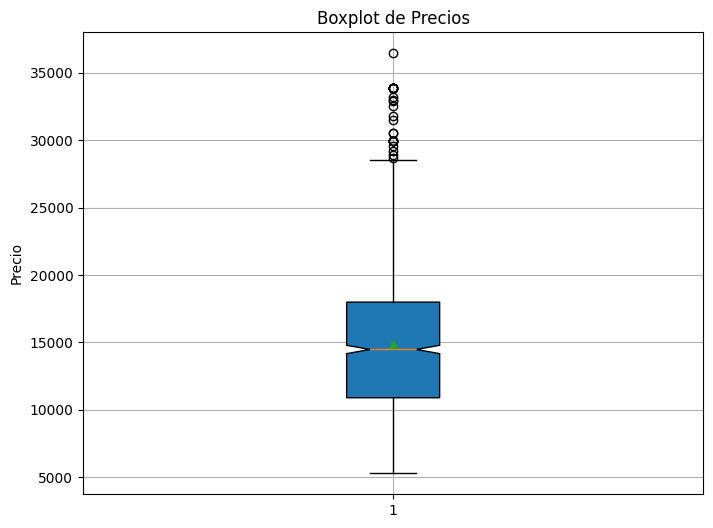

In [6]:
precios_gas = data["price"]
plt.figure(figsize=(8, 6))
plt.boxplot(precios_gas, notch=True, vert=True, patch_artist=True, showmeans=True)
plt.title('Boxplot de Precios')
plt.ylabel('Precio')
plt.grid(True)
plt.show()

The outliers were checked manually throught the data source, and we could confirmed that they are not outliers

In [7]:
Q1 = data['price'].quantile(0.25)
Q2 = data['price'].quantile(0.5)  # Esta es la mediana
Q3 = data['price'].quantile(0.75)
IQR = Q3 - Q1

upper_whisker = (Q3 + 1.5 * IQR)
print(upper_whisker)

data[data["price"]>upper_whisker][["price", "brand"]].sort_values(by='price', ascending=False)

28625.0


,price,brand
idx,,
48483,36441,DFSK
37736,33900,EVO
24917,33900,EVO
91054,33900,EVO
43137,33900,EVO
40872,33900,EVO
85825,33900,EVO
43076,33900,EVO
34644,33899,PIAGGIO


### Gas , Numerical variables selection

In [8]:
def fill_gas_numerical_columns(numerical_columns: pd.DataFrame) -> pd.DataFrame:
    #fill the elemental columns that has a minor amount of missing data with the mode
    numerical_columns = Data_processor.fill_na_with_mode(numerical_columns, "dimensions.length")
    numerical_columns = Data_processor.fill_na_with_mode(numerical_columns, "dimensions.height")

    #fill the missing data witch regression, the parameters were based on the relation matrix 
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["dimensions.length", "dimensions.height"], y_column="dimensions.width")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["dimensions.length", "dimensions.height", "dimensions.width"], y_column="trunkCapacityInLiters")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["power_cv", "power_kw"], y_column="maxSpeed")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["power_cv", "power_kw", "maxSpeed"], y_column="acceleration")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["power_cv", "power_kw", "maxSpeed"], y_column="acceleration")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["Llantas_Diametro_cm", "power_kw"], y_column="max_torque_nm")

    numerical_columns.dropna(axis=1, inplace=True)
    return numerical_columns

def get_gas_numerical_columns (data: pd.DataFrame) -> pd.DataFrame:
    numerical_columns = data.select_dtypes(include=['number'])
    numerical_columns.drop(columns=[ "car_id"], inplace=True)

    #if all the values of the numerical columns is 0, we remove the column
    cols_to_drop = numerical_columns.columns[(numerical_columns == 0).all()]
    numerical_columns = numerical_columns.drop(cols_to_drop, axis=1)

    #Remove the column with all NAs
    max_nans = 6586
    thresh = numerical_columns.shape[0] - max_nans

    numerical_columns.dropna(axis=1, thresh=thresh+1, inplace=True)
    return fill_gas_numerical_columns(numerical_columns)

def get_gas_categorical_columns(df: pd.DataFrame) -> pd.DataFrame:
    ret = df.select_dtypes(include=['category'])
    ret = ret.drop(columns=["environmentalLabel"]) #All of the cars of this dataframes are electrical which implies 0 emission
    ret = Data_processor.remove_redundand_columns(ret)
    ret = Data_processor.impute_categorical_mode(df=ret, X=["brand", "model"], Y="version")
    ret = Data_processor.impute_categorical_mode(df=ret, X=["brand", "model"], Y="jato_classification")
    ret = Data_processor.impute_categorical_mode(df=ret, X=["brand", "model", "traction"], Y="brakes")
    ret = Data_processor.impute_categorical_mode(df=ret, X=["brand", "model", "traction","brakes"], Y="front_suspension")
    ret = Data_processor.impute_categorical_mode(df=ret, X=["brand", "model", "traction","brakes"], Y="rear_suspension")
    return ret

In [9]:
numerical_columns = get_gas_numerical_columns(data)
categorical_columns = get_gas_categorical_columns(data)

Regression mape ['dimensions.length', 'dimensions.height'] -> dimensions.width: 1.9674673980367798%
Regression mape ['dimensions.length', 'dimensions.height', 'dimensions.width'] -> trunkCapacityInLiters: 15.456430834096604%
Regression mape ['power_cv', 'power_kw'] -> maxSpeed: 5.050674953115151%
Regression mape ['power_cv', 'power_kw', 'maxSpeed'] -> acceleration: 4.822246491513302%
Regression mape ['power_cv', 'power_kw', 'maxSpeed'] -> acceleration: 3.454631907673101%
Regression mape ['Llantas_Diametro_cm', 'power_kw'] -> max_torque_nm: 9.788386626797596%
Number of missing values in 'version' before filling with 'unknown': 0
Number of missing values in 'jato_classification' before filling with 'unknown': 6
Number of missing values in 'brakes' before filling with 'unknown': 6
Number of missing values in 'front_suspension' before filling with 'unknown': 0
Number of missing values in 'rear_suspension' before filling with 'unknown': 0


In [10]:
correlation_matrix = numerical_columns.corr()["price"]
print(correlation_matrix)

price                    1.000000
km                      -0.666253
year                     0.630371
cubicCapacity            0.134931
doors                    0.196730
seatingCapacity          0.262632
trunkCapacityInLiters    0.200050
maxSpeed                 0.029122
acceleration            -0.190765
power_cv                 0.438754
power_kw                 0.444135
max_torque_nm            0.351313
speakers                 0.187856
dimensions.width         0.315454
dimensions.height        0.161946
dimensions.length        0.305562
Numero_Testigos          0.010558
displacement_liters      0.132262
displacement_cc          0.171891
number_of_cylinders     -0.147125
compression_ratio       -0.511080
Llantas_Diametro_cm      0.512251
price_categ              0.890447
Name: price, dtype: float64


In [11]:
scaler = StandardScaler()
df_scaled  = scaler.fit_transform(numerical_columns)

pca = PCA(n_components=2)
principal_components = pca.fit_transform(df_scaled)
df_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

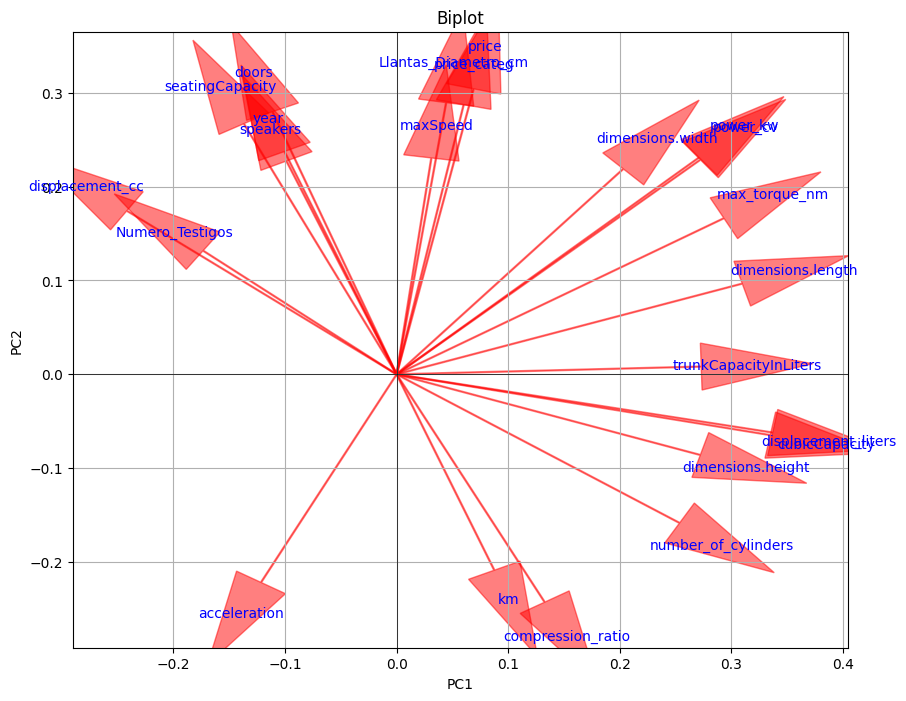

In [12]:
def biplot(score, coeff, labels=None):
    plt.figure(figsize=(10, 8))
    origin = [0, 0]  # Origen de las flechas

    # Dibujar las flechas
    for i in range(len(coeff)):
        plt.arrow(origin[0], origin[1], coeff[i,0], coeff[i,1], color='r', alpha=0.5, head_width=0.05, head_length=0.1)
        if labels is not None:
            plt.text(coeff[i,0]*1.15, coeff[i,1]*1.15, labels[i], color='blue', ha='center', va='center')

    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("Biplot")
    plt.grid(True)
    plt.axhline(0, color='black',linewidth=0.5)
    plt.axvline(0, color='black',linewidth=0.5)
    plt.xlim(min(coeff[:,0])*1.2, max(coeff[:,0])*1.2)
    plt.ylim(min(coeff[:,1])*1.2, max(coeff[:,1])*1.2)
    plt.show()

# Llamada a la función biplot
biplot(principal_components, np.transpose(pca.components_[0:2, :]), labels=numerical_columns.columns)

## CART regression with only numerical values

- Using only numerical values we can use the SMOTE technique to generate synthetic value data and rebalance our unbalance dataset.

### SMOTE

In [13]:
X = numerical_columns.drop(columns=["price_categ","price"]) # + price_categ
y = numerical_columns["price_categ"]

In [14]:
# Train-Test Split Before Applying SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

Training the CART Model (Decision Tree) on Resampled Data

In [16]:
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train_resampled, y_train_resampled)

DecisionTreeClassifier(random_state=42)

In [17]:
y_pred = clf.predict(X_test)

# Cell 7: Evaluate the Model
# Print classification report and confusion matrix
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           1       0.70      0.79      0.74        58
           2       0.79      0.71      0.75        96
           3       0.82      0.87      0.84        91
           4       0.38      0.33      0.35         9
           8       1.00      0.50      0.67         4

    accuracy                           0.77       258
   macro avg       0.74      0.64      0.67       258
weighted avg       0.77      0.77      0.77       258

Confusion Matrix:
 [[46 12  0  0  0]
 [17 68 11  0  0]
 [ 3  6 79  3  0]
 [ 0  0  6  3  0]
 [ 0  0  0  2  2]]


After analyzing the results obtained with and without the application of SMOTE, it was observed that models trained without SMOTE demonstrated superior performance in terms of accuracy and stability. Although SMOTE is an effective technique for balancing imbalanced datasets by synthesizing new samples, in this specific case, the models without SMOTE outperformed those with it. 

**Therefore future models will be trained without SMOTE from this point forward.**

# Clasification


In [18]:
def eval_classification(y_test, y_pred):
    result = pd.DataFrame({"Real": y_test, "Prediction": y_pred})
    result["diff"] = result["Real"] - result["Prediction"]
    Evaluator.eval_ordinal_classification(diff=abs(result["diff"]))

def classify(X_train, X_test, y_train, y_test , classifier, classifier_name = None) -> None:
    classifier = classifier
    classifier.fit(X_train, y_train)

    # Predicting the test set results
    y_pred = classifier.predict(X_test)
    eval_classification(y_test, y_pred)

    if classifier_name != None:
        return Evaluator.eval_classification(y_pred = y_pred,  y_true=y_test, binary_classification=False, classifier_name=classifier_name)
    return Evaluator.eval_classification(y_pred = y_pred, y_true=y_test, binary_classification=False)



In [19]:
gas_cars = pd.merge(numerical_columns, categorical_columns, left_index=True, right_index=True, how='inner')
numerical_column_names = list(numerical_columns.columns)
categorical_column_names = list(categorical_columns.columns)

target = gas_cars[["price", "price_categ"]]
gas_cars.drop(columns=["price"], inplace=True)

numerical_column_names.remove("price")


encoders_and_scalers = {}
for column in numerical_column_names:
    scaler = StandardScaler()
    gas_cars[[column]] = scaler.fit_transform(gas_cars[[column]])
    encoders_and_scalers[column] = scaler 

gas_cars_encoded = pd.get_dummies(gas_cars, columns=categorical_column_names)

### CART

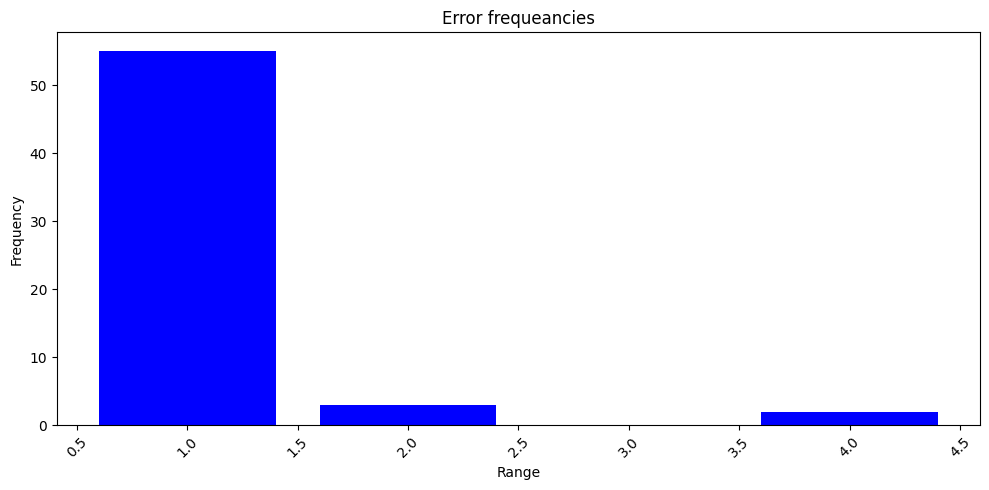

{1: 55, 2: 3, 4: 2}
Error mean: 1.15
Error rate: 23.25581395348837 %
Overall mean: 0.26744186046511625
Accuracy: 0.7674418604651163 
 Precision: 0.7689591958835639 
 Recall: 0.7674418604651163 
 F1 Score: 0.7643601405381009
Confusion Matrix:
 [[45 13  0  0  0]
 [17 65 13  1  0]
 [ 1  4 83  3  0]
 [ 0  1  5  3  0]
 [ 0  0  0  2  2]]


In [20]:
classify(X_train, X_test, y_train, y_test, DecisionTreeClassifier(random_state=42), classifier_name="CART")

### Random forest
Random forest can get a better result at a higher computational time cost

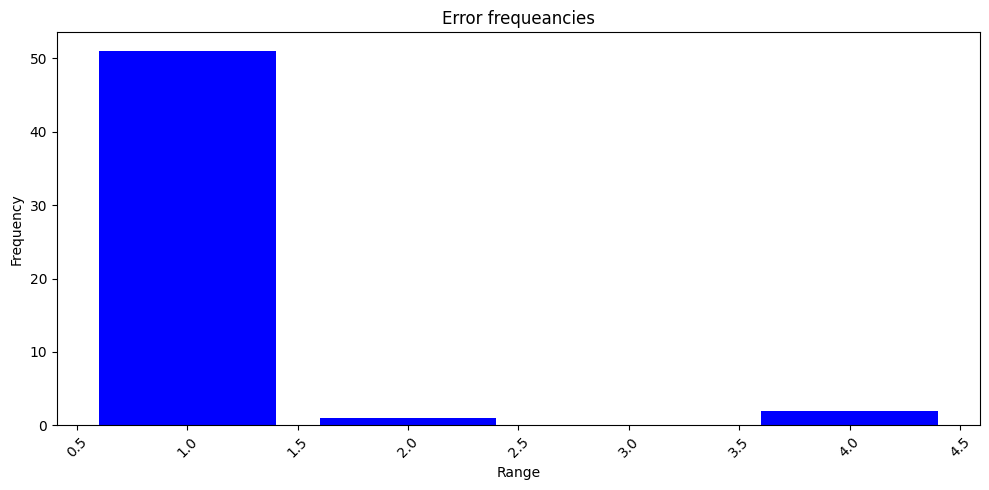

{1: 51, 2: 1, 4: 2}
Error mean: 1.1296296296296295
Error rate: 20.930232558139537 %
Overall mean: 0.2364341085271318
Accuracy: 0.7906976744186046 
 Precision: 0.7939097042779214 
 Recall: 0.7906976744186046 
 F1 Score: 0.7863415877661094
Confusion Matrix:
 [[47 11  0  0  0]
 [12 67 17  0  0]
 [ 1  2 85  3  0]
 [ 0  0  6  3  0]
 [ 0  0  0  2  2]]


In [21]:
classify(X_train, X_test, y_train, y_test, RandomForestClassifier(random_state=42), classifier_name="RandomForestClassifier")

### SVM
Much higher computational cost, more distributed error, but in overall worse result

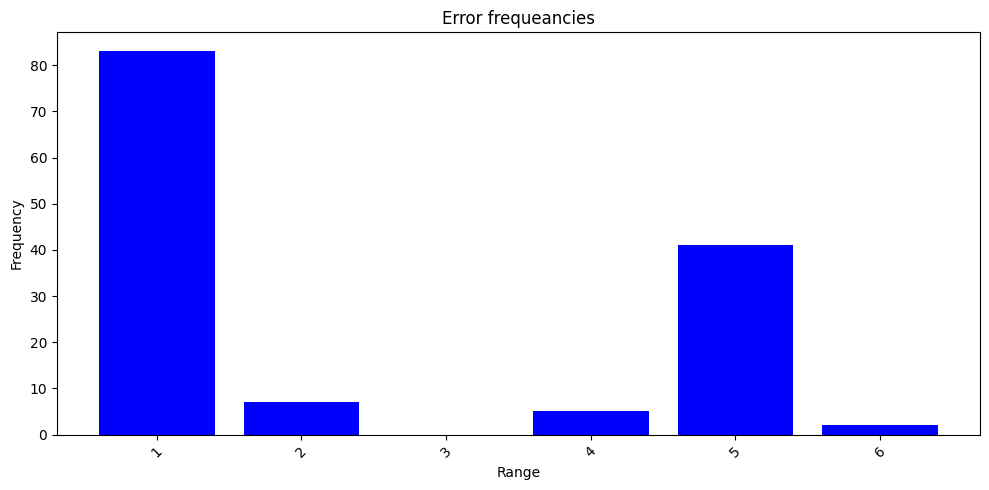

{1: 83, 2: 7, 4: 5, 5: 41, 6: 2}
Error mean: 2.420289855072464
Error rate: 53.48837209302325 %
Overall mean: 1.2945736434108528
Accuracy: 0.46511627906976744 
 Precision: 0.562289460251711 
 Recall: 0.46511627906976744 
 F1 Score: 0.4722225450461908
Confusion Matrix:
 [[38 20  0  0  0]
 [28 55 11  0  2]
 [ 3 24 23  0 41]
 [ 0  4  0  0  5]
 [ 0  0  0  0  4]]


/home/lingfeng/Desktop/cuml/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [22]:
classify(X_train_resampled, X_test, y_train_resampled, y_test, SVC(random_state=42), classifier_name="SVC")

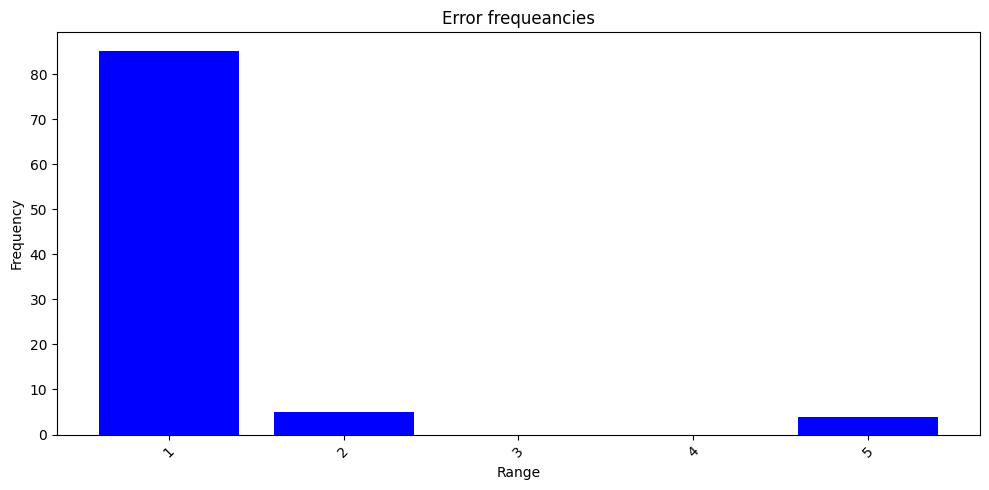

{1: 85, 2: 5, 5: 4}
Error mean: 1.2234042553191489
Error rate: 36.434108527131784 %
Overall mean: 0.44573643410852715
Accuracy: 0.6356589147286822 
 Precision: 0.6266624016261602 
 Recall: 0.6356589147286822 
 F1 Score: 0.6156027536790515
Confusion Matrix:
 [[25 32  1  0  0]
 [ 9 73 14  0  0]
 [ 0 25 66  0  0]
 [ 0  4  5  0  0]
 [ 0  0  4  0  0]]


/home/lingfeng/Desktop/cuml/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [23]:
classify(X_train, X_test, y_train, y_test, SVC(random_state=42), classifier_name="SVC")

### Naive bayes

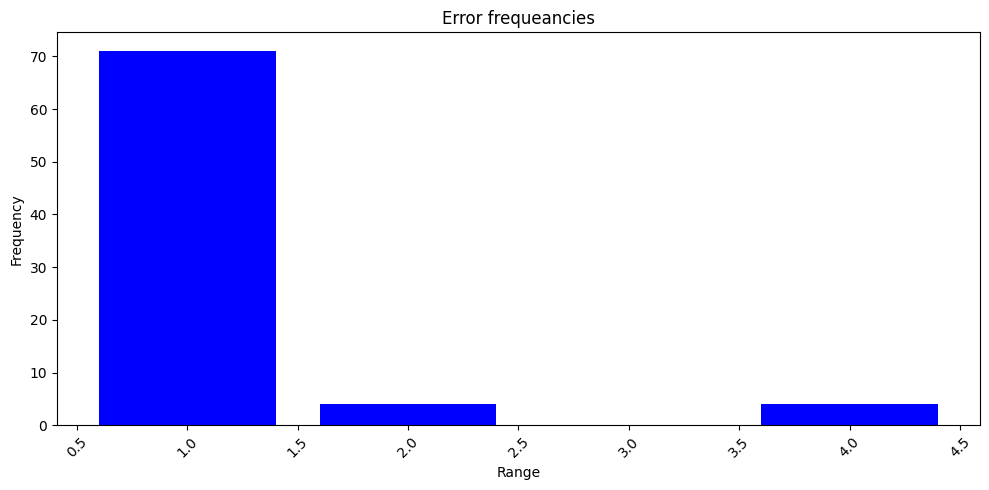

{1: 71, 2: 4, 4: 4}
Error mean: 1.2025316455696202
Error rate: 30.620155038759687 %
Overall mean: 0.3682170542635659
Accuracy: 0.6937984496124031 
 Precision: 0.7016163384017858 
 Recall: 0.6937984496124031 
 F1 Score: 0.6956799419622178
Confusion Matrix:
 [[43 14  1  0  0]
 [20 59 16  1  0]
 [ 2 13 70  6  0]
 [ 0  0  2  5  2]
 [ 0  0  0  2  2]]


In [24]:
classify(X_train, X_test, y_train, y_test, GaussianNB(), classifier_name="Naive bayes")

### ANN

In [25]:
encoder = OneHotEncoder(sparse_output=False)
y_encoded = encoder.fit_transform(data[['price_categ']])

# Step 2: Split the data
X_train, X_test, y_train, y_test = train_test_split(
    gas_cars_encoded, y_encoded, test_size=0.3, random_state=42
)

# Step 3: Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 4: Define the ANN model
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(64, activation='tanh'))
model.add(Dense(32, activation='tanh'))
model.add(Dense(y_train.shape[1], activation='softmax'))  # Softmax for multi-class classification

# Step 5: Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Step 6: Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=128)

/home/lingfeng/Desktop/cuml/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1734822596.925952   21858 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2279 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
W0000 00:00:1734822597.182298   21957 gpu_backend_lib.cc:579] Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice. This may result in compilation or runtime failures, if the program we try to run uses routines from libdevice.
Searched for CUDA in the following directories:
  ./cuda_sdk_lib
  ipykernel_launcher.runfiles/cuda_nvcc
  ipykern/cuda_nvcc
  
  /usr/local/cuda
  /home/lingfeng/Desktop/cum

Epoch 1/100


I0000 00:00:1734822598.799416   21953 service.cc:148] XLA service 0x78c53400b770 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734822598.799695   21953 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2024-12-22 00:09:58.894913: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
E0000 00:00:1734822599.030356   21953 cuda_dnn.cc:522] Loaded runtime CuDNN library: 9.1.0 but source was compiled with: 9.3.0.  CuDNN library needs to have matching major version and equal or higher minor version. If using a binary install, upgrade your CuDNN library.  If building from sources, make sure the library loaded at runtime is compatible with the version specified during compile configuration.
E0000 00:00:1734822599.042681   21953 cuda_dnn.cc:522] Loaded runtime CuDNN library: 9.1.0 but s

FailedPreconditionError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/home/lingfeng/Desktop/cuml/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/lingfeng/Desktop/cuml/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/lingfeng/Desktop/cuml/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/lingfeng/Desktop/cuml/lib/python3.12/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.12/asyncio/base_events.py", line 641, in run_forever

  File "/usr/lib/python3.12/asyncio/base_events.py", line 1987, in _run_once

  File "/usr/lib/python3.12/asyncio/events.py", line 88, in _run

  File "/home/lingfeng/Desktop/cuml/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/lingfeng/Desktop/cuml/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/lingfeng/Desktop/cuml/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/lingfeng/Desktop/cuml/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/lingfeng/Desktop/cuml/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/lingfeng/Desktop/cuml/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/home/lingfeng/Desktop/cuml/lib/python3.12/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/lingfeng/Desktop/cuml/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/home/lingfeng/Desktop/cuml/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/home/lingfeng/Desktop/cuml/lib/python3.12/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/home/lingfeng/Desktop/cuml/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/home/lingfeng/Desktop/cuml/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/home/lingfeng/Desktop/cuml/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_21858/1625366539.py", line 25, in <module>

  File "/home/lingfeng/Desktop/cuml/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/lingfeng/Desktop/cuml/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 368, in fit

  File "/home/lingfeng/Desktop/cuml/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 216, in function

  File "/home/lingfeng/Desktop/cuml/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 129, in multi_step_on_iterator

DNN library initialization failed. Look at the errors above for more details.
	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_multi_step_on_iterator_1644]

In [ ]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [ ]:
Evaluator.eval_classification(y_pred=y_pred_classes, y_true=y_test_classes, binary_classification=False, classifier_name="ANN")

Accuracy: 0.8863049095607235 
 Precision: 0.8958501438954609 
 Recall: 0.8863049095607235 
 F1 Score: 0.8874106157618791
Confusion Matrix:
 [[ 68   5   0   0   0]
 [  6 124   7   1   0]
 [  0  13 141   7   0]
 [  0   0   1   7   0]
 [  0   0   4   0   3]]


## Regression

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(gas_cars_encoded, precios_gas, test_size=0.3, random_state=42)

In [ ]:
def regression(X_train, X_test, y_train, y_test , regressor, regressor_name = None) -> None:
    regressor = regressor
    regressor.fit(X_train, y_train)
    # Predicting the test set results
    y_pred = regressor.predict(X_test)

    if regressor_name != None:
        Evaluator.eval_regression(y_pred = y_pred, bins=5, y_true=y_test, plot=False, n_features=X_train.shape[1], regressor_name=regressor_name)
    Evaluator.eval_regression(y_pred = y_pred, y_true=y_test, plot=False)

### Cart

In [ ]:
regression(X_train, X_test, y_train, y_test , DecisionTreeRegressor(random_state=42), regressor_name="CART")

MAE: 778.6821705426356 
 MSE: 1756751.4832041343 
 RMSE: 1325.4250198348204 
 R2: 0.9392498322248869 
 MAPE: 5.435493931683752
Mean: 778.6821705426356
Variance: 1150405.5604831441
Standard Deviation: 1072.569606358088
r2_adjusted: 1.0027535890983084
MAE: 778.6821705426356 
 MSE: 1756751.4832041343 
 RMSE: 1325.4250198348204 
 R2: 0.9392498322248869 
 MAPE: 5.435493931683752
Mean: 778.6821705426356
Variance: 1150405.5604831441
Standard Deviation: 1072.569606358088


### Cart Optimized Hyperparameters with Optuna

### Random Forest

In [ ]:
regression(X_train, X_test, y_train, y_test , RandomForestRegressor(random_state=42), regressor_name="RandomForest")

MAE: 698.2293453919034 
 MSE: 1191656.5749760407 
 RMSE: 1091.6302372946807 
 R2: 0.9587913614690262 
 MAPE: 4.729197986887422
Mean: 698.2293453919034
Variance: 704132.3562096347
Standard Deviation: 839.1259477632871
r2_adjusted: 1.001867841060704
MAE: 698.2293453919034 
 MSE: 1191656.5749760407 
 RMSE: 1091.6302372946807 
 R2: 0.9587913614690262 
 MAPE: 4.729197986887422
Mean: 698.2293453919034
Variance: 704132.3562096347
Standard Deviation: 839.1259477632871


### SVM Regression

In [ ]:
regression(X_train, X_test, y_train, y_test , SVR(kernel='rbf'), regressor_name="SVR")

MAE: 4216.647411894322 
 MSE: 29859873.379807062 
 RMSE: 5464.4188510588265 
 R2: -0.032583341986641035 
 MAPE: 29.52476290334598
Mean: 4216.647411894322
Variance: 12079757.983571967
Standard Deviation: 3475.594623020925
r2_adjusted: 1.0468033313770366
MAE: 4216.647411894322 
 MSE: 29859873.379807062 
 RMSE: 5464.4188510588265 
 R2: -0.032583341986641035 
 MAPE: 29.52476290334598
Mean: 4216.647411894322
Variance: 12079757.983571967
Standard Deviation: 3475.594623020925


### Multivariable regression

In [ ]:
linear_regressor = LinearRegression()
linear_regressor.fit(X_train, y_train)

# Predicting the test set results
y_pred = linear_regressor.predict(X_test)

# Optionally, display the coefficients of the model
print("Coefficients:", linear_regressor.coef_)
print("Intercept:", linear_regressor.intercept_)

Coefficients: [-9.72066670e+02  9.40721446e+02 -1.26367561e+06 ...  0.00000000e+00
  0.00000000e+00 -5.16689193e+05]
Intercept: -2663826.9492717073


In [ ]:
result = pd.DataFrame({"Real": y_test, "Prediction": y_pred})
result["diff"] = result["Real"].to_numpy() - result["Prediction"].to_numpy()

In [ ]:
result

,Real,Prediction,diff
idx,,,
162056,17500,3.186831e+05,-3.011831e+05
39072,14800,1.483133e+04,-3.133034e+01
116181,14990,3.805065e+04,-2.306065e+04
45240,8590,8.043361e+03,5.466390e+02
156962,16900,1.048415e+06,-1.031515e+06
...,...,...,...
63532,11500,1.120786e+04,2.921360e+02
79243,11487,1.189770e+04,-4.106989e+02
37736,33900,4.902806e+04,-1.512806e+04


 ### ANN

In [ ]:
# Define the model
model = Sequential()

model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='linear'))
model.add(Dense(1))


c:\Users\marti\Desktop\asignaturas\machineLearning\Cars_Price_Prediction\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [ ]:
# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=128)


Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 243423792.0000 - mae: 14712.0547 - val_loss: 258338400.0000 - val_mae: 15146.6865
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 252862464.0000 - mae: 14977.0771 - val_loss: 258225456.0000 - val_mae: 15143.0557
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 245225376.0000 - mae: 14769.0596 - val_loss: 257942880.0000 - val_mae: 15134.0166
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 241638416.0000 - mae: 14662.2061 - val_loss: 257268064.0000 - val_mae: 15112.5068
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 240109280.0000 - mae: 14617.1240 - val_loss: 255786816.0000 - val_mae: 15065.3564
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 241429360.0000 - mae: 14663.3555 - val_loss: 252771696.0000 - val_mae: 14968.7930
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 244229248.0000 - mae: 14743.6924 - val_loss: 246977840.0000 - val_mae: 14782.0410
Epoch 8/100
8/8 ━━━━

In [ ]:
loss, mae = model.evaluate(X_test, y_test, verbose=2)
print(f"Mean Absolute Error on test set: {mae:.2f}")

13/13 - 0s - 3ms/step - loss: 1745304.5000 - mae: 945.1630
Mean Absolute Error on test set: 945.16


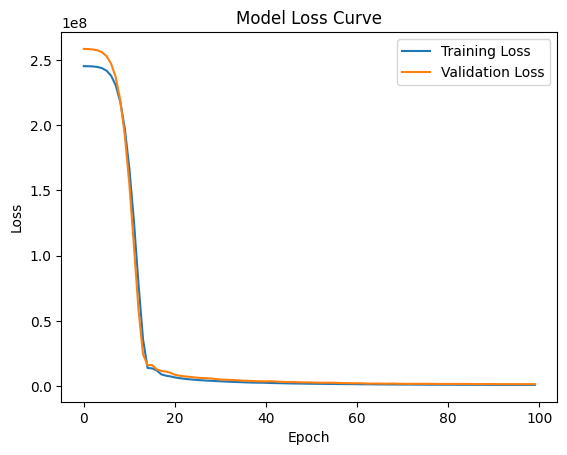

In [ ]:
# Plot the loss curve
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss Curve')
plt.show()

In [ ]:
y_pred = model.predict(X_test).flatten()

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [ ]:
Evaluator.eval_regression(y_pred=y_pred, y_true=y_test, plot=False, n_features=X_train.shape[1], regressor_name="ANN")

MAE: 945.1629638671875 
 MSE: 1745304.570115722 
 RMSE: 1321.099757821385 
 R2: 0.9396456480026245 
 MAPE: 6.451168651917662
Mean: 945.1629887859334
Variance: 851971.4947449635
Standard Deviation: 923.023019618126
r2_adjusted: 1.0027356481764897


,bin_label,mean,variance,std_dev,max_error,min_error,n_sample
0,"(11180.0, 5590.0]",739.233154,474881.260170,689.116289,3221.743164,3.692383,106
1,"(16770.0, 11180.0]",889.760357,667045.555833,816.728569,3735.890625,1.590820,142
2,"(22360.0, 16770.0]",837.362370,659756.574443,812.254009,3794.447266,28.265625,104


In [ ]:
Evaluator.save("gas")

Regression results saved to: evaluation/gas_regression.tex
Classification results saved to: evaluation/gas_classification.tex


# Hyperparameter Tunning

In [26]:
master = MasterGenerator(X=gas_cars_encoded.drop(columns=["price_categ"]), y_categ=gas_cars_encoded["price_categ"], y_numeric=precios_gas, n_tries=5, CUML=True, name="HP_gas")

In [30]:
master.CUML = False
master._classification_generate()

[I 2024-12-22 00:13:25,362] A new study created in memory with name: no-name-c52433eb-d440-4582-a7ba-1a4486e3eef6
[W 2024-12-22 00:13:25,411] Trial 0 failed with parameters: {'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 5} because of the following error: ValueError('Unknown label type: continuous. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.').
Traceback (most recent call last):
  File "/home/lingfeng/Desktop/cuml/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/home/lingfeng/Desktop/repos/Cars_Price_Prediction/Trees/../utils/classifier_generator.py", line 93, in <lambda>
    study.optimize(lambda trial: self._objective(trial, method), n_trials=n_trials)
                                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/lingfeng/Desktop/repos/Cars_Price_Prediction/Trees/../utils/

Optimizing method: decision_tree
Error with method decision_tree: Unknown label type: continuous. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.
Optimizing method: random_forest
Error with method random_forest: Unknown label type: continuous. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.
Optimizing method: svc


[W 2024-12-22 00:13:25,572] Trial 0 failed with parameters: {'C': 0.14500767424745029, 'kernel': 'poly', 'gamma': 'auto'} because of the following error: ValueError('Unknown label type: continuous. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.').
Traceback (most recent call last):
  File "/home/lingfeng/Desktop/cuml/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/home/lingfeng/Desktop/repos/Cars_Price_Prediction/Trees/../utils/classifier_generator.py", line 93, in <lambda>
    study.optimize(lambda trial: self._objective(trial, method), n_trials=n_trials)
                                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/lingfeng/Desktop/repos/Cars_Price_Prediction/Trees/../utils/classifier_generator.py", line 77, in _objective
    model.fit(self.X_train, self.y_train)
  File "/home/lingfeng/De

Error with method svc: Unknown label type: continuous. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.
